In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from funcoes_ajuda import descritiva
import time

In [3]:
# Carregar os dados titanic, já tratada conforme a primeira aula.
titanic = pd.read_pickle('/root/MBA_USP_Data_Science_Analytics/11. Árvores, Redes e Ensemble Models/Dados/aula3_titanic1.pkl')
titanic.head()

,survived,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


In [4]:
# Verificar valores ausentes.
print(titanic.isnull().sum())

survived      0
pclass        0
age           0
sibsp         0
parch         0
fare          0
sex_male      0
embarked_Q    0
embarked_S    0
dtype: int64


In [5]:
# Gera 80% de treino e 20% de teste.
# Separar variáveis preditoras e resposta.
X = titanic.drop('survived', axis=1)
y = titanic['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2360873)

# Sempre importante conferir a cada passo!
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(712, 8)
(712,)
(179, 8)
(179,)


In [8]:
# Parâmetros do GridSearchCV.
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3],
    'gamma': [0],
    'learning_rate': [0.1, 0.4],
    'colsample_bytree': [0.6, 0.8],
    'min_child_weight': [1],
    'subsample': [0.75, 1]
}

In [12]:
# Instanciar a classe do XGB.
tempo_ini = time.time()

xgb = XGBClassifier(objective='binary:logistic', random_state=2360873)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=10, verbose=0, n_jobs=-1)

In [13]:
# Treinar o XGB já com o grid search.
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=2360873, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8], 'gamma': [0],
                         'learning_rate': [0.1, 0.4], 'max_depth': [2, 3],
                         'min_child_weight': [1],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.75, 1]},
             scoring='roc_auc')

In [14]:
# Tempo final.
tempo_fim = time.time()
print(f"Tempo de execução: {tempo_fim - tempo_ini} segundos")

Tempo de execução: 38.03551506996155 segundos


Avaliação base de treino: AUC = 0.97
Avaliação base de teste: AUC = 0.83


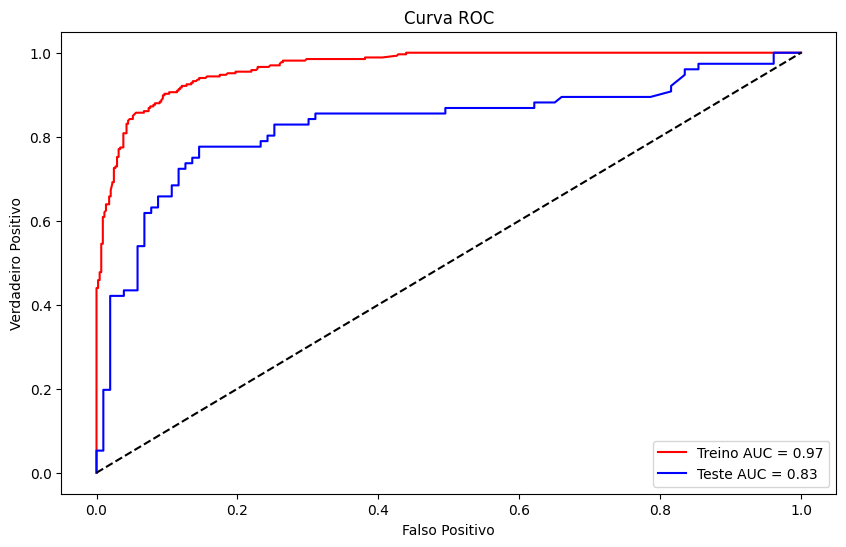

In [15]:
# Avaliar o XGBoosting.
def avalia(modelo, X_train, y_train, X_test, y_test):
    p_train = modelo.predict_proba(X_train)[:, 1]
    # c_train = modelo.predict(X_train)
    
    p_test = modelo.predict_proba(X_test)[:, 1]
    # c_test = modelo.predict(X_test)

    auc_train = roc_auc_score(y_train, p_train)
    auc_test = roc_auc_score(y_test, p_test)
    
    print(f'Avaliação base de treino: AUC = {auc_train:.2f}')
    print(f'Avaliação base de teste: AUC = {auc_test:.2f}')
    
    fpr_train, tpr_train, _ = roc_curve(y_train, p_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, p_test)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, color='red', label=f'Treino AUC = {auc_train:.2f}')
    plt.plot(fpr_test, tpr_test, color='blue', label=f'Teste AUC = {auc_test:.2f}')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadeiro Positivo')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

avalia(grid_search.best_estimator_, X_train, y_train, X_test, y_test)

/root/MBA_USP_Data_Science_Analytics/11. Árvores, Redes e Ensemble Models/Boosting/funcoes_ajuda.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette='viridis', alpha=0.5, ax=ax2)


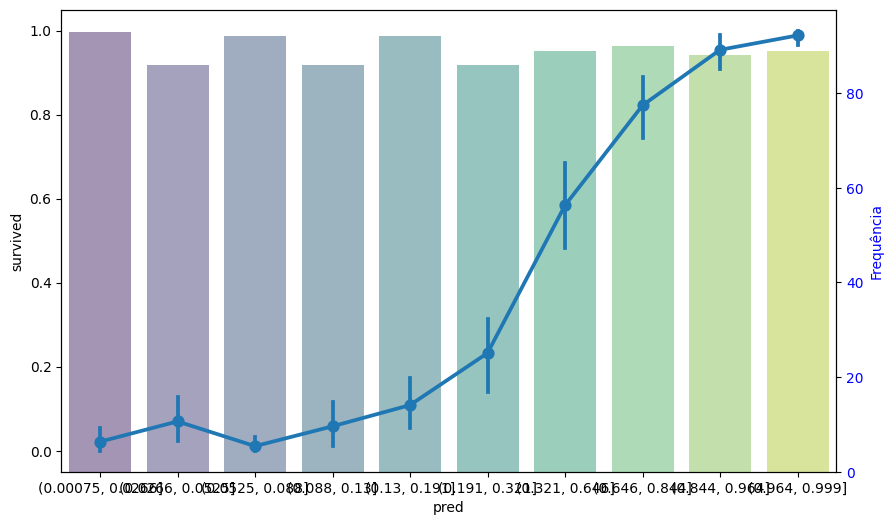

In [17]:
# Avaliando a previsão do modelo.
titanic['pred'] = grid_search.best_estimator_.predict_proba(X)[:, 1]
descritiva(titanic, 'pred', vresp='survived', max_classes=10)